### EE658/758 Machine Learning Assignment 2

* Data preprocessing & EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data.csv')
df.head()

,-6,592,0
0,-5,807,0
1,-5,-344,0
2,-5,-126,0
3,-5,243,0
4,-5,185,0


In [3]:
df.shape

(199, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   -6      199 non-null    int64
 1   592     199 non-null    int64
 2   0       199 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


In [5]:
df.dtypes

-6     int64
592    int64
0      int64
dtype: object

In [6]:
df.describe()

,-6,592,0
count,199.000000,199.000000,199.000000
mean,0.964824,325.477387,0.582915
std,3.636761,286.265167,0.494321
min,-5.000000,-445.000000,0.000000
25%,-2.000000,152.500000,0.000000
50%,1.000000,349.000000,1.000000
75%,4.000000,538.000000,1.000000
max,8.000000,1056.000000,1.000000


In [7]:
df.isnull().sum()

-6     0
592    0
0      0
dtype: int64

In [8]:
df[df.duplicated()]

,-6,592,0
40,-3,421,1
169,5,454,1


In [9]:
df.shape

(199, 3)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(197, 3)

In [12]:
df.rename(columns={'-6':'Feature1','592':'Feature2','0':'Label'},inplace=True)

In [13]:
df.head()

,Feature1,Feature2,Label
0,-5,807,0
1,-5,-344,0
2,-5,-126,0
3,-5,243,0
4,-5,185,0


In [14]:
df.to_csv('updated_data.csv')

In [15]:
df.nunique()

Feature1     14
Feature2    180
Label         2
dtype: int64

In [16]:
# Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## A) Logistic Regression 

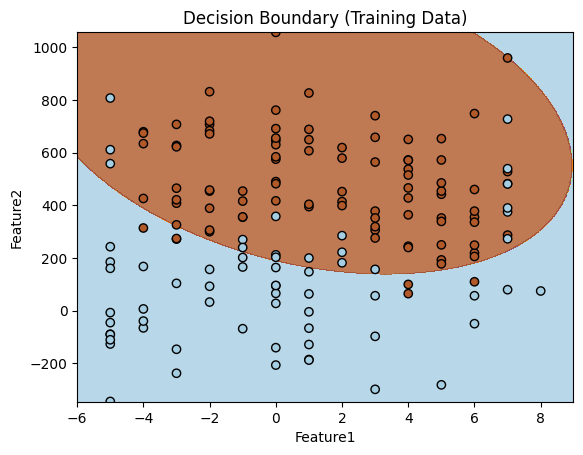

Model Accuracy: 77.50%


In [17]:
class LogisticRegressionModel:
    def __init__(self, degree=2):
        self.model = LogisticRegression()
        self.scaler = StandardScaler()
        self.poly_features = PolynomialFeatures(degree=degree)
        self.is_fitted = False
        
    def preprocess_data(self, X):
        if not self.is_fitted:
            raise ValueError("Scaler and PolynomialFeatures are not fitted. Call 'fit_and_transform' before preprocessing data.")
        X_scaled = self.scaler.transform(X)
        X_poly = self.poly_features.transform(X_scaled)
        return X_poly
    
    def fit_and_transform(self, X):
        self.scaler.fit(X)
        X_scaled = self.scaler.transform(X)
        self.poly_features.fit(X_scaled)
        self.is_fitted = True
        return self.preprocess_data(X)
    
    def train_model(self, X_train, y_train):
        X_train_preprocessed = self.fit_and_transform(X_train)
        self.model.fit(X_train_preprocessed, y_train)
        
    def plot_decision_boundary(self, X, y, title):
        h = .02  # Step size in the mesh
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        X_mesh_preprocessed = self.preprocess_data(X_mesh)
        
        Z = self.model.predict(X_mesh_preprocessed)
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
        plt.title(title)
        plt.xlabel('Feature1')
        plt.ylabel('Feature2')
        plt.show()

    def evaluate_model(self, X_test, y_test):
        X_test_preprocessed = self.preprocess_data(X_test)
        y_pred = self.model.predict(X_test_preprocessed)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model Accuracy: {accuracy:.2%}")

# Splitting
X_train, X_test, y_train, y_test = train_test_split(df[['Feature1', 'Feature2']], df['Label'], test_size=0.2, random_state=42)

# Initializing Logistic Regression Model
log_reg_model = LogisticRegressionModel()

# Training the model
log_reg_model.train_model(X_train, y_train)

# Plotting Decision Boundary for Training Data
log_reg_model.plot_decision_boundary(X_train.values, y_train.values, 'Decision Boundary (Training Data)')

# Evaluating the model on Testing Data
log_reg_model.evaluate_model(X_test, y_test)


## B) Implementation of  Logistic Regression from Scratch without scikit-learn

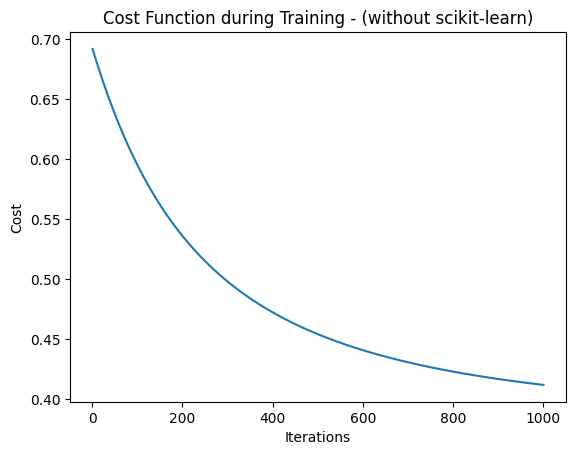

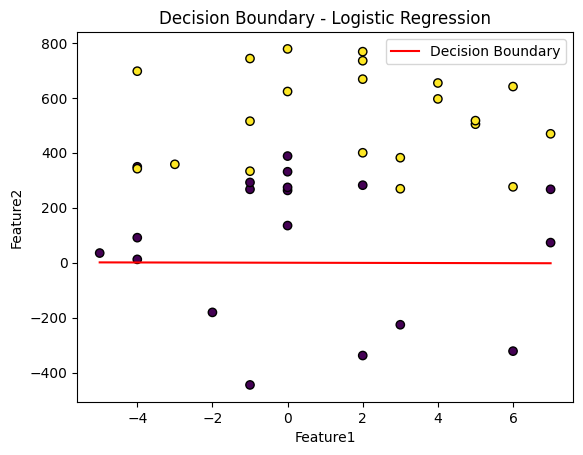

Model Accuracy: 65.00%


In [29]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    cost = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    costs = []

    for _ in range(iterations):
        h = sigmoid(X @ theta)
        gradient = (1/m) * X.T @ (h - y)
        theta -= alpha * gradient
        cost = compute_cost(X, y, theta)
        costs.append(cost)

    return theta, costs

def plot_decision_boundary(X, y, theta):
    x_values = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', marker='o')
    y_values = -(theta[0] + theta[1] * x_values) / theta[2]
    plt.plot(x_values, y_values, label='Decision Boundary', color='red')
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plt.title('Decision Boundary - Logistic Regression')
    plt.legend()
    plt.show()

def evaluate_model(X, y, theta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    predictions = sigmoid(X_b @ theta)
    predictions = (predictions >= 0.5).astype(int)
    accuracy = accuracy_score(y, predictions)
    print(f"Model Accuracy: {accuracy*100:.2f}%")

# Assuming X_train and X_test are your original feature matrices
X_train, X_test, y_train, y_test = train_test_split(df[['Feature1', 'Feature2']], df['Label'], test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Bias
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

# Initialize theta with zeros
initial_theta = np.zeros(X_train_b.shape[1])

# Parameters
learning_rate = 0.01
num_iterations = 1000

# Training
trained_theta, costs = gradient_descent(X_train_b, y_train, initial_theta, learning_rate, num_iterations)

# Cost Function For Every Iterations
plt.plot(range(1, num_iterations + 1), costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function during Training - (without scikit-learn)')
plt.show()

# Plot Decision Boundary
plot_decision_boundary(X_test.values, y_test.values, trained_theta)

# Evaluate the Model
evaluate_model(X_test.values, y_test.values, trained_theta)


## C) Implementation of  Logistic Regression + Feature Engineering

In [19]:
df = pd.read_csv('updated_data.csv')

In [20]:
df.head()

,Unnamed: 0,Feature1,Feature2,Label
0,0,-5,807,0
1,1,-5,-344,0
2,2,-5,-126,0
3,3,-5,243,0
4,4,-5,185,0


In [21]:
df.drop(columns='Unnamed: 0',inplace=True)

In [22]:
df.shape

(197, 3)

In [23]:
df.isnull().sum()

Feature1    0
Feature2    0
Label       0
dtype: int64

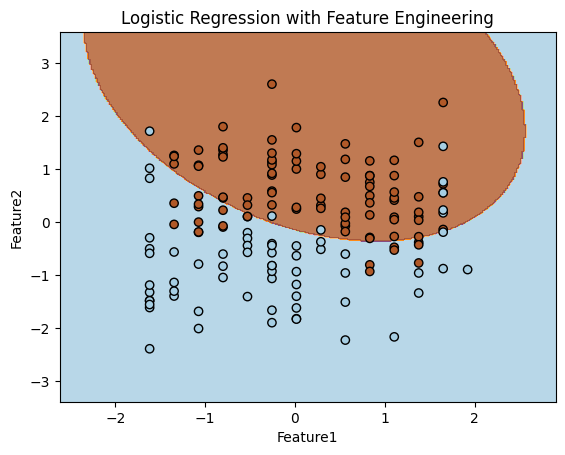

Model Accuracy with Feature Engineering: 77.50%


In [24]:
def create_polynomial_features(df, degree=2):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(df[['Feature1', 'Feature2']])
    poly_feature_names = [f'poly_{i}' for i in range(X_poly.shape[1])]
    df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)
    df_poly['Label'] = df['Label']
    return df_poly, poly

def split_data(df_poly):
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
        df_poly.iloc[:, :-1], df_poly['Label'], test_size=0.2, random_state=42)
    return X_train_poly, X_test_poly, y_train_poly, y_test_poly

def standardize_data(X_train_poly, X_test_poly):
    scaler_poly = StandardScaler()
    X_train_scaled_poly = scaler_poly.fit_transform(X_train_poly)
    X_test_scaled_poly = scaler_poly.transform(X_test_poly)
    return X_train_scaled_poly, X_test_scaled_poly, scaler_poly

def train_logistic_regression(X_train_scaled_poly, y_train_poly):
    model_poly_sklearn = LogisticRegression()
    model_poly_sklearn.fit(X_train_scaled_poly, y_train_poly)
    return model_poly_sklearn

def plot_decision_boundary(X, y, model, poly, title):
    h = .02
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    meshgrid_poly = poly.transform(np.c_[xx.ravel(), yy.ravel()])

    Z = model.predict(meshgrid_poly)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 1], X[:, 2], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plt.show()

def evaluate_model(model, X_test_scaled_poly, y_test_poly):
    y_pred_poly_sklearn = model.predict(X_test_scaled_poly)
    accuracy_poly_sklearn = accuracy_score(y_test_poly, y_pred_poly_sklearn)
    print(f"Model Accuracy with Feature Engineering: {accuracy_poly_sklearn:.2%}")

# Assuming df is your original DataFrame
df_poly, poly = create_polynomial_features(df, degree=2)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = split_data(df_poly)
X_train_scaled_poly, X_test_scaled_poly, scaler_poly = standardize_data(X_train_poly, X_test_poly)
model_poly_sklearn = train_logistic_regression(X_train_scaled_poly, y_train_poly)
plot_decision_boundary(X_train_scaled_poly, y_train_poly, model_poly_sklearn, poly, 'Logistic Regression with Feature Engineering')
evaluate_model(model_poly_sklearn, X_test_scaled_poly, y_test_poly)


In [25]:
X_train_poly.shape, X_test_poly.shape, y_train_poly.shape, y_test_poly.shape

((157, 6), (40, 6), (157,), (40,))

## D)Implementation of Logistic Regression from Scratch with Feature Engineering

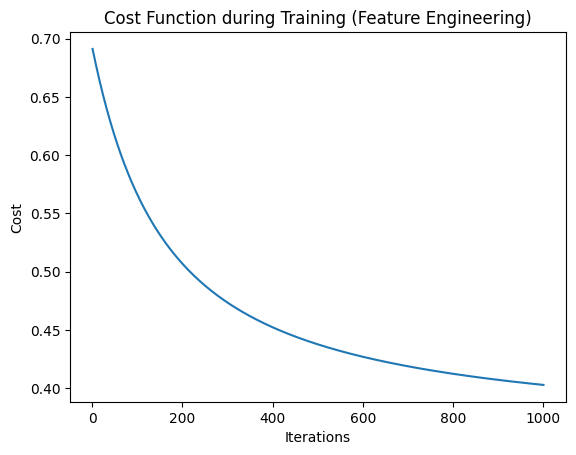

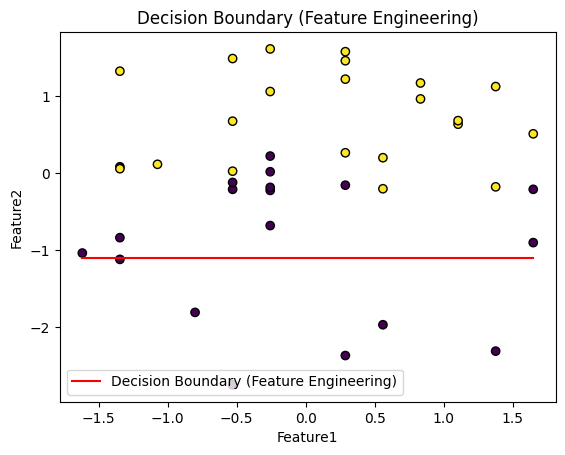

Model Accuracy : 80.00%


In [26]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    cost = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    costs = []

    for i in range(iterations):
        h = sigmoid(X @ theta)
        gradient = (1/m) * X.T @ (h - y)
        theta -= alpha * gradient
        cost = compute_cost(X, y, theta)
        costs.append(cost)

    return theta, costs

X_train_poly_scaled = X_train_poly.copy()
X_test_poly_scaled = X_test_poly.copy()

# Scaling
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

# Bias
X_train_poly_b = np.c_[np.ones((X_train_poly_scaled.shape[0], 1)), X_train_poly_scaled]
X_test_poly_b = np.c_[np.ones((X_test_poly_scaled.shape[0], 1)), X_test_poly_scaled]

initial_theta_poly = np.zeros(X_train_poly_b.shape[1])

# Parameters
learning_rate_poly = 0.01
num_iterations_poly = 1000

# Training
trained_theta_poly, costs_poly = gradient_descent(X_train_poly_b, y_train_poly, initial_theta_poly, learning_rate_poly, num_iterations_poly)

# Cost Function For Every Iterations
plt.plot(range(1, num_iterations_poly + 1), costs_poly)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function during Training (Feature Engineering)')
plt.show()

x_values_poly = np.linspace(X_test_poly_scaled[:, 1].min(), X_test_poly_scaled[:, 1].max(), 100)
plt.scatter(X_test_poly_scaled[:, 1], X_test_poly_scaled[:, 2], c=y_test_poly, cmap='viridis', edgecolors='k', marker='o')
y_values_poly = -(trained_theta_poly[0] + trained_theta_poly[1] * x_values_poly) / trained_theta_poly[2]
plt.plot(x_values_poly, y_values_poly, label='Decision Boundary (Feature Engineering)', color='red')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Decision Boundary (Feature Engineering)')
plt.legend()
plt.show()

# Evalution of Accuracy
predictions_poly = sigmoid(X_test_poly_b @ trained_theta_poly)
predictions_poly = (predictions_poly >= 0.5).astype(int)
accuracy_poly = accuracy_score(y_test_poly, predictions_poly)
print(f"Model Accuracy : {accuracy_poly*100:.2f}%")
